This imports needed libraries and sets the path so that Octave can find Dynare. 

In [1]:
#!pip install --upgrade oct2py
import numpy as np
from oct2py import octave
import matplotlib.pyplot as plt
import os
from scipy.optimize import root
import pickle
octave.addpath('C:/dynare/6.1/matlab')
#octave.addpath(os.path.expanduser('C:/Users/blankenw/GitHub/dynare_progs/np_1'))

    _pyeval at line 57 column 30

    _pyeval at line 57 column 30



'.;C:\\Users\\blankenw\\AppData\\Local\\anaconda3\\Lib\\site-packages\\oct2py;C:\\Users\\blankenw\\AppData\\Local\\anaconda3\\Lib\\site-packages\\octave_kernel;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\9.1.0\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\site\\oct\\api-v59\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\9.1.0\\site\\m;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\api-v59\\m;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\m;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\m\\once_only;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\m\\startup;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\9.1.0\\oct\\x86_64-w64-mingw32;C:\\Program Fi

Declare 
* Which variable will be permanently changed
* What the new value will be
* How many periods to track 

In [2]:
var_change='a_0'
var_change_val=.4
periods=200

`DyPy` is a class that we create and store in a file called `MyPy.py`. It will be used to create instances of a class called DyPy. 

In [3]:
from MyPy import DyPy

Creates a file called `t_call.m`. This containts information on the function called in Dynare.  It is included in the `.mod` file via: `@#include "t_call.m"` in `model_1.mod`

In [4]:
with open('t_call.m', 'w') as file:
    file.write(f"perfect_foresight_setup(periods={periods},endval_steady);\n")
    file.write("perfect_foresight_solver(print);\n")

 `make_model.ipyn` writes a file called `t_model.m`. `t_model.m`is the `model` block in the Dynare `.mod` file.  The created file is included in the `.mod` file via `@#include "t_model.m"` in `model_1.mod`. 

In [5]:
%run make_model.ipynb

`make_files_1.ipynb` creates dictionaries of parameters and piclkes them for use in `make_files_2`. The pickeling is needed in order to be able to run `make_files_2` as a stand-alone program (rather than calling `main`) which is done often in development. Items in `make_files_1` are set only once in running `main`. The only exception is the paramter with the permanent shock. Items in `makefiles_2` are updated as we go through the three cases of 1) no adjusment costs 1) labor adjusment costs 3) capital adjustment costs.

In [6]:
%run make_files_1.ipynb

List of dictionaries that will be used to iterate through the three cases of 1) no adjusment costs 1) labor adjusment costs 3) capital adjustment costs. 

In [7]:
new_pars = [{'psi_n': 0, 'psi_k': 0}, 
           {'psi_n': 2, 'psi_k': 0}, 
           {'psi_n': 0, 'psi_k': 2}]


Will contain a list of the instances of DyPy. 

In [8]:
t=[]

Makes a call to Octave, which makes a call to Dynare. Then the `.mod` file is run in Dynare. Output from Dynare is displayed as it runs.

This iterates through through the three cases of 1) no adjusment costs 1) labor adjusment costs 3) capital adjustment costs. 
* updates the parameters distionary with a dictionary from the list new_pars.
* pickels results for use in `make_files2`.
* `octave.dynare` is using `oct2py` to called dynare via Octave, since Python cannot interact directly with Dynare.
* Pulls the main output file `oo_` from Octave to current memory. 
* Pull and auxilery file `M_` to current memory
* Renames the simulation data from `oo`
* Renames the set of names from `M_` file. Note #M_['endo_names'] is a cell object and each item in this cell is a cell. We need to pull out the first item in each sub-list.
* Creates an instance of DyPy. This makes items in `endo_simul` into attributes of t[0] (or t[1], or t[2]). Now, for example, t[0].n_0 is available. Attribute for each endogenous item. 
* Appends the current instance of t.

In [9]:

for i, update in enumerate(new_pars):
    model_params.update(update)
    with open('mf1.pkl', 'wb') as f:
        pickle.dump((ss_params,model_params,ss_shock), f)
    %run make_files_2.ipynb
    with open('mf2.pkl', 'rb') as f:
        ss_dict = pickle.load(f)
    octave.dynare('model_1.mod')
    oo = octave.pull('oo_')
    M_ = octave.pull('M_')
    endo_simul = oo['endo_simul']
    endo_names = [item[0] for item in M_['endo_names']] 
    instance=DyPy(endo_simul,endo_names)
    t.append(instance)  
    

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  0.000e+00 ...  2.254e-14 -2.354e-14]
       x: [ 4.367e-01  2.817e-01 ...  8.732e-01  4.946e-01]
    nfev: 43
    fjac: [[-5.743e-02  2.997e-10 ... -4.062e-03 -3.745e-03]
           [-4.430e-02 -1.868e-10 ...  5.659e-02  2.572e-03]
           ...
           [-3.798e-01 -2.909e-01 ... -2.530e-01 -2.548e-01]
           [ 6.835e-02 -6.817e-02 ...  3.461e-03  2.112e-03]]
       r: [-1.741e+01  1.335e+00 ...  6.800e-01  2.139e-01]
     qtf: [-3.376e-11 -1.206e-11 ...  6.245e-13  4.643e-13]
Starting Dynare (version 6.1).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Substitution of exo leads: added 3 auxiliary variables and equations.
Found 17 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
3 block(s) found:
  2 recursive block(s) and 1 simultan

Creates additional data from the fields (method attributes) above. 

In [10]:
for instance in t:
    
    instance.ns_0 = instance.n_0/instance.s_0
    instance.ns_1 = instance.n_1/instance.s_1
    instance.ns_2 = instance.n_2/instance.s_2
    instance.y_0 = instance.c_0+instance.i
    

The function called from plotting. 

In [11]:
def plot_dta(instances, attributes,periods=100):    # takes a list of instances and a list of attributes to plot. Instance are t[0], t[1], and t[2]. `attributes` is a list of attributes such a 'c_0', 'c_1', c_2.
    plt.figure(figsize=(15, 5))                     # sets the size of the figure that will contain the subplots.              
    for j, attribute in enumerate(attributes):      # iterates over the attributes to plot.
        # Create a subplot for this attribute
        plt.subplot(1, len(attributes), j+1)        # creates a subplot for each attribute in the list `attributes`.
        for i, instance in enumerate(instances):    # iterates over the instances to plot.
            
            attr_value = getattr(instance, attribute) # gets the attribute value for the attribute in the list `attributes` given the current instance.
            attr_value = attr_value.reshape(-1, 1)      # reshapes the attribute value to a column vector.
            length = attr_value.shape[0]
            tm = np.linspace(1, length, length)     # creates a time vector for the attribute value.
            # Add a line to the plot for this time series
            plt.plot(tm[0:periods], attr_value[0:periods], label=labels[i]) # plots the attribute value for for the instance.

        plt.title(attribute)                    # sets the title of the subplot to the attribute name.
        plt.legend()                            # adds a legend to the subplot.

    # Show the figure with all subplots

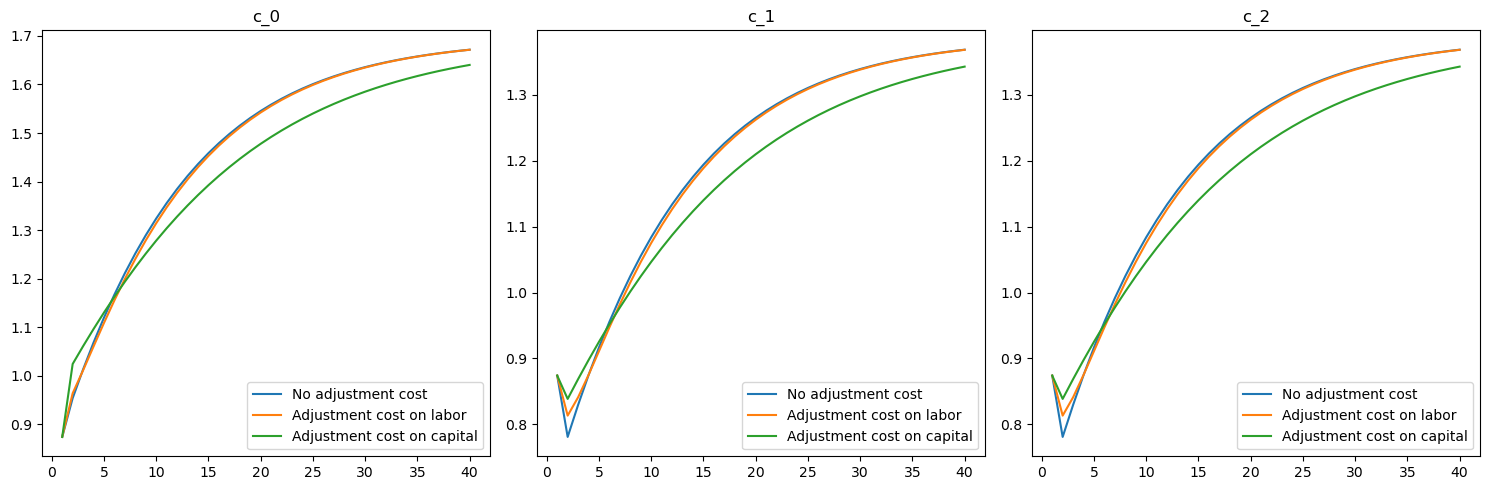

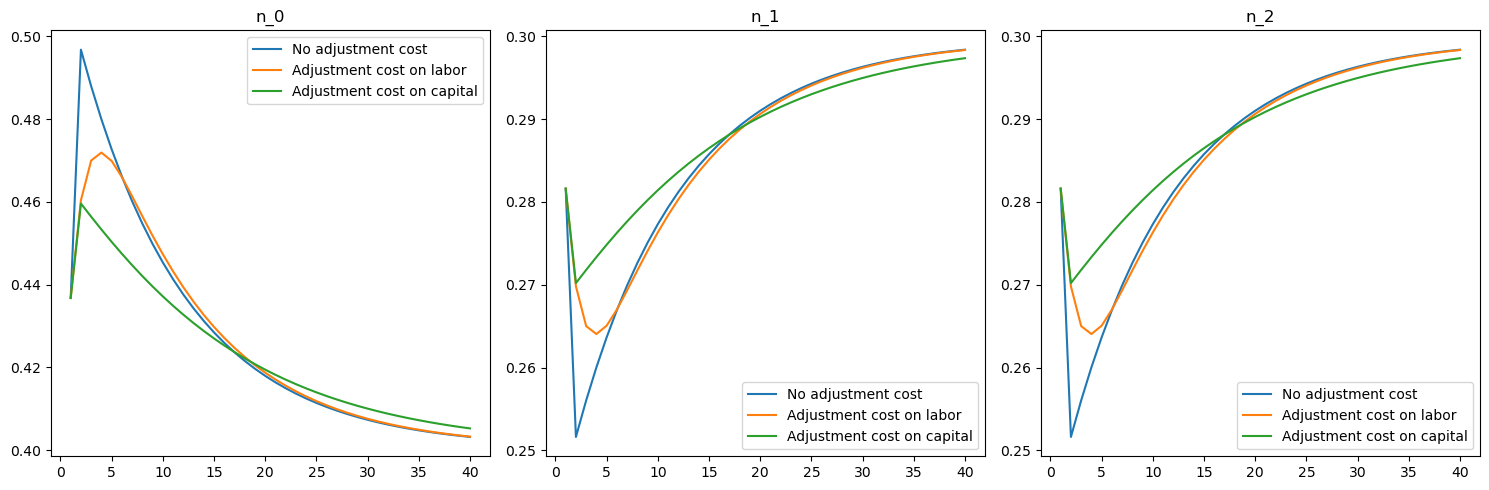

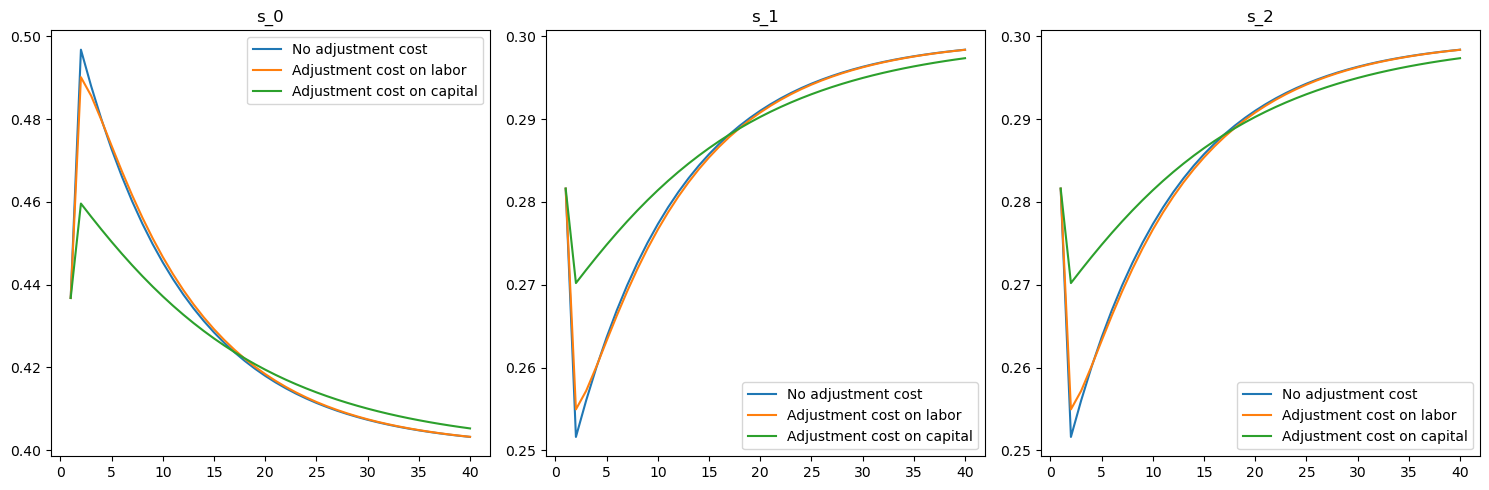

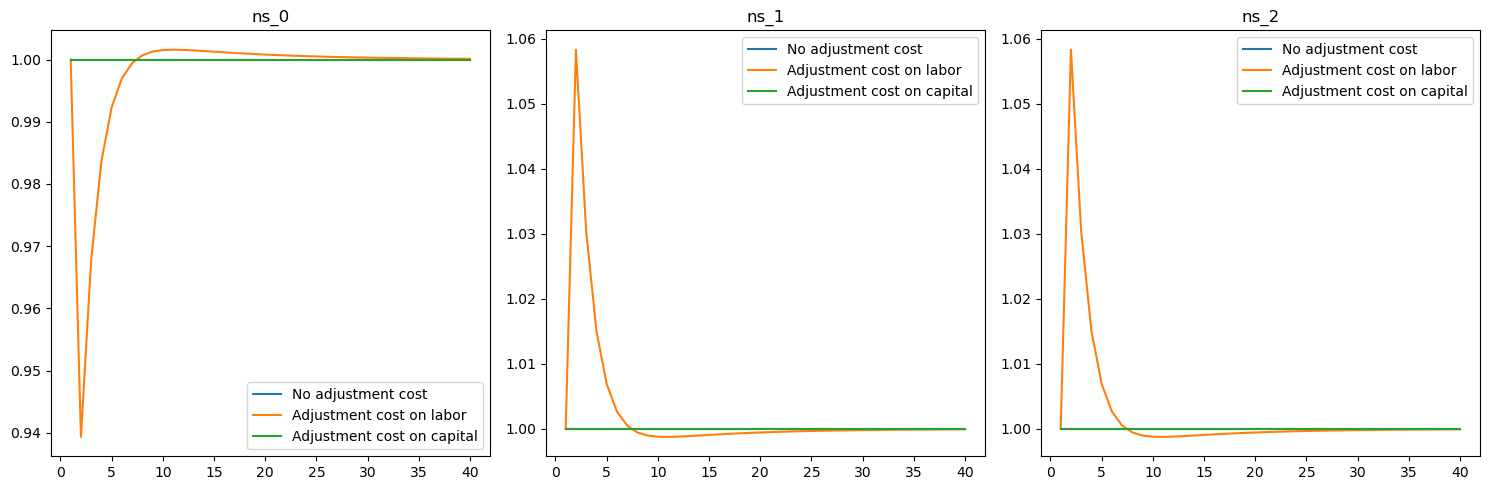

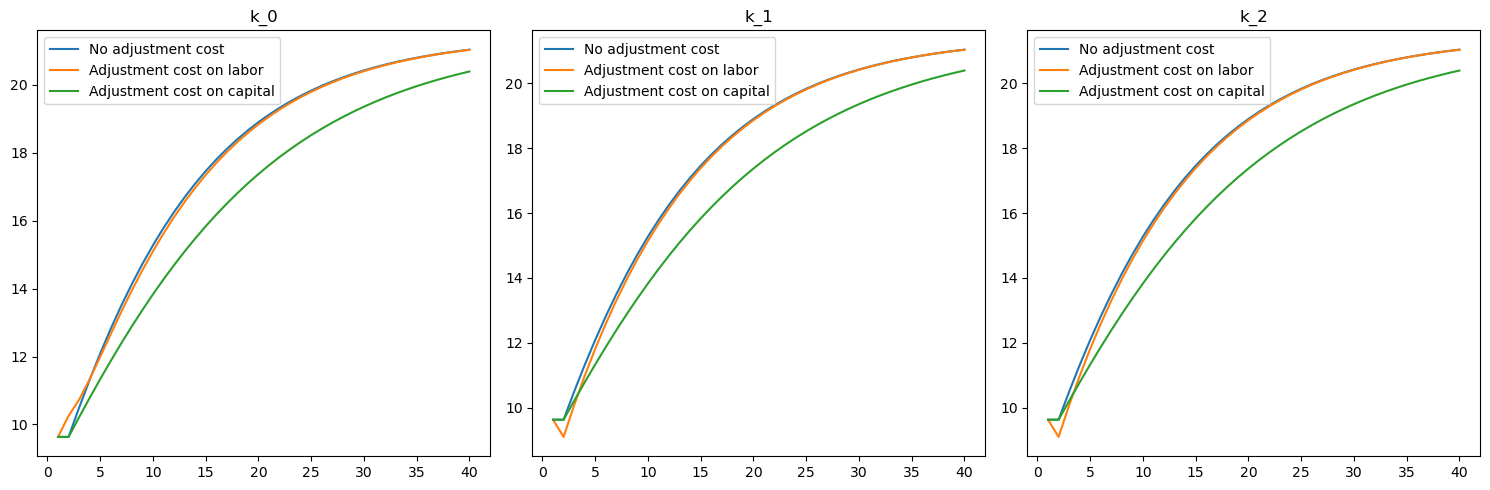

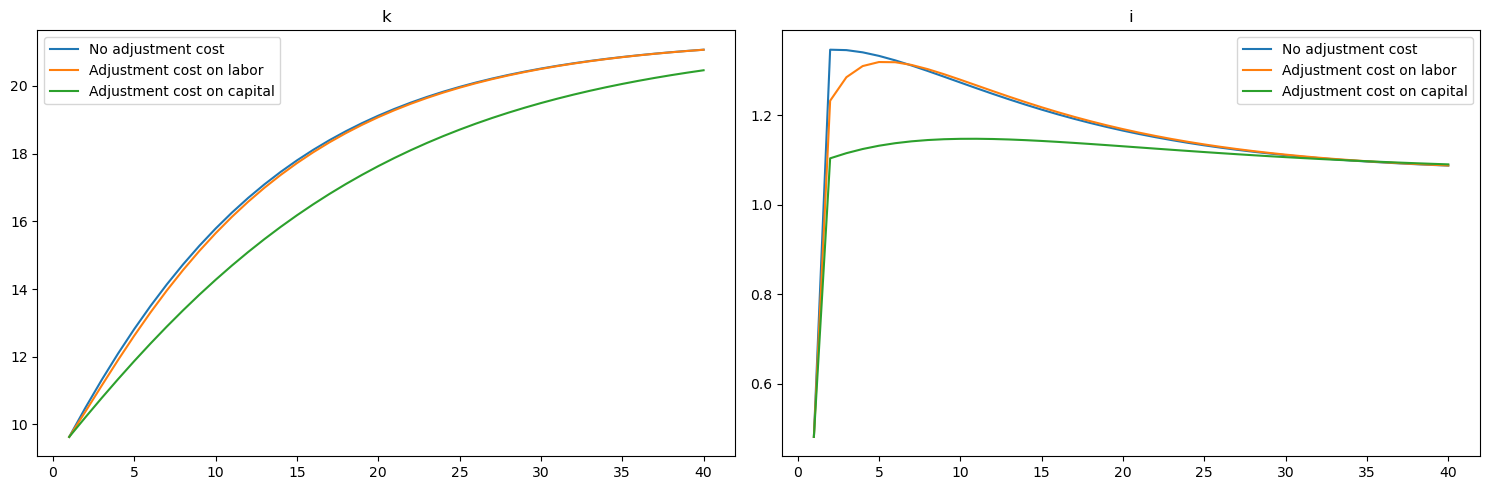

In [12]:
labels = ['No adjustment cost', 'Adjustment cost on labor', 'Adjustment cost on capital']

all_attributes =[['c_0', 'c_1', 'c_2'],
                    ['n_0', 'n_1', 'n_2'],
                    ['s_0', 's_1', 's_2'],
                    ['ns_0', 'ns_1', 'ns_2'],
                    ['k_0', 'k_1', 'k_2'],
                    ['k', 'i'],
                   
                     ]
for attributes in all_attributes:       # iterates over the list of attributes to plot.
    plot_dta(t, attributes,periods=40)
    plt.tight_layout()
    plt.show()                  


In [13]:
oo

{'dynare_version': '6.1',
 'exo_simul': array([[0. , 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.

In [14]:
oo

{'dynare_version': '6.1',
 'exo_simul': array([[0. , 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.

In [15]:
oo

{'dynare_version': '6.1',
 'exo_simul': array([[0. , 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.4, 0. , 0. ],
        [0.